In [70]:
import cftime
from datetime import timedelta
from datetime import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal

import mission_tools

%matplotlib widget

In [2]:
# Load mission 19 data and plot tracks over the radar image
mission_nc_path = '../../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Load the breaker dataset
breaker_df = pd.read_csv('../../microSWIFT_data/breaker_df.csv')
breaker_df_mission19 = breaker_df[breaker_df['mission number'] == 19]

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30311/1949518407.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30311/1949518407.py:22: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.g

(18908.77766203704, 18908.778125)

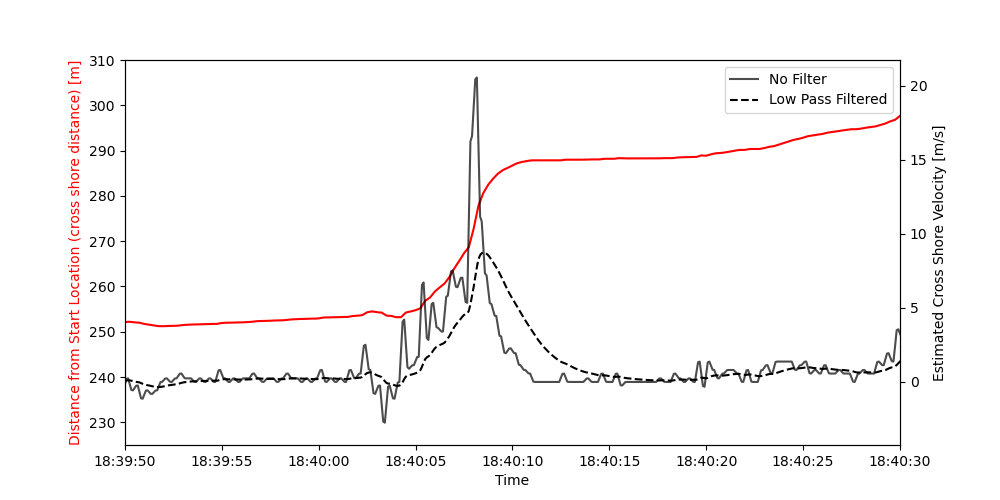

In [7]:
# Apply low pass filter to velocity 
# Compute Cross Shore Velocity 
trajectory_num = 5
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
cross_shore_vel = np.gradient((x_locations[trajectory_num,0] - x_locations[trajectory_num,:]), 1/12)
cross_shore_vel = np.ma.filled(cross_shore_vel, np.NaN)
sos = signal.butter(1, 0.1, 'lowpass', fs=12, output='sos')
cross_shore_vel_filtered = signal.sosfilt(sos, cross_shore_vel)

# Convert times to actual datetimes
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) + 250 # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)

fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
ax1.plot(time, x_locations[trajectory_num,0] - x_locations[trajectory_num,:], color='r')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='r')
ax1.set_ylim(225, 310)

# Cross Shore Velocity
ax2 = ax1.twinx()
ax2.plot(time, cross_shore_vel, label='No Filter', color='k', alpha=0.7)
ax2.plot(time, cross_shore_vel_filtered, label='Low Pass Filtered', color='k', linestyle='dashed')
ax2.set_ylabel('Estimated Cross Shore Velocity [m/s]')

ax2.legend()
ax1.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))

In [10]:
# Compute Stokes Drift Estimate from offshore conditions
# load the offshore wave conditon dataframe
offshore_df = pd.read_csv('../../microSWIFT_data/mission_df.csv')
mission_19_df = offshore_df[offshore_df['mission number'] == 19]
g = 9.8 
Tm = mission_19_df['Tm [s]'].values[0]
Hs = mission_19_df['Hs [m]'].values[0]
stokes_drift = (((2 * np.pi)**3 / g) * Hs**2 / Tm**3)
print(stokes_drift)

0.16783500593077116


In [76]:
# Depth Along Trajectory
tracjectory_bathy = mission_tools.bathy_along_track(bathy_file='../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                    xFRF=x_locations[trajectory_num, :], 
                                                    yFRF=y_locations[trajectory_num, :],
                                                    single_trajectory=True)

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(tracjectory_bathy * 9.8))[0]
print(phase_speed_along_track)

[7.68903485 7.68903485 7.68903485 ... 5.82418627 5.82418627 5.82418627]


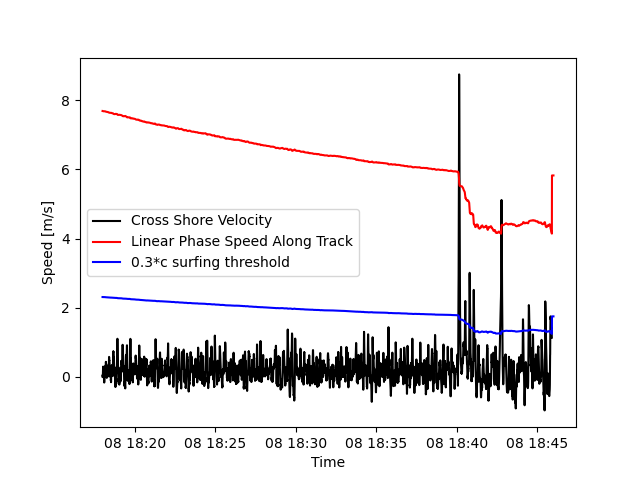

In [78]:
fig, ax = plt.subplots()
ax.plot(time, cross_shore_vel_filtered, color='k', label='Cross Shore Velocity')
ax.plot(time, phase_speed_along_track, color='r', label='Linear Phase Speed Along Track')
ax.plot(time, phase_speed_along_track*0.3, color='b', label='0.3*c surfing threshold')
ax.set_xlabel('Time')
ax.set_ylabel('Speed [m/s]')
ax.legend()

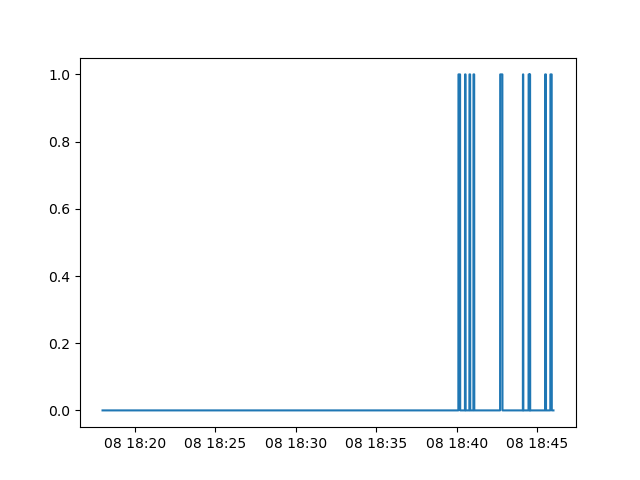

In [79]:
# Find all times that the cross shore velocity is higher than the threshold
jump_threshold = phase_speed_along_track * 0.3
jump_times = np.zeros(cross_shore_vel_filtered.size)
jump_inds = np.where(cross_shore_vel_filtered > jump_threshold)
jump_times[jump_inds] = 1
fig, ax = plt.subplots()
ax.plot(time, jump_times)

Text(0, 0.5, 'Distance from Start Location (cross shore distance) [m]')

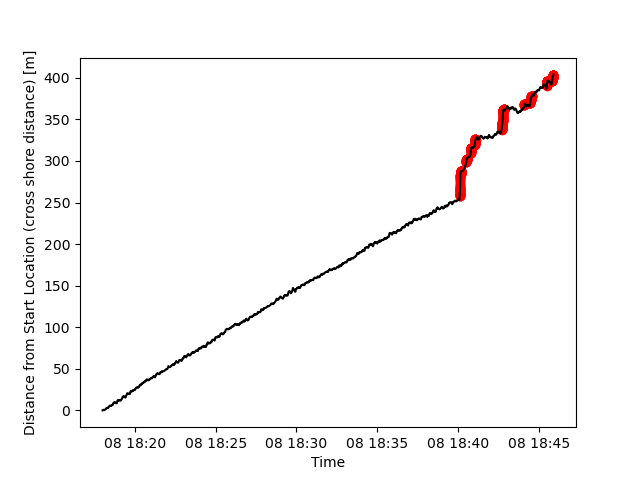

In [80]:
fig, ax = plt.subplots()
dist_traveled = x_locations[trajectory_num,0] - x_locations[trajectory_num,:]
ax.plot(time, dist_traveled, color='k')
ax.scatter(time[jump_inds], dist_traveled[jump_inds], color='r')
ax.set_xlabel('Time')
ax.set_ylabel('Distance from Start Location (cross shore distance) [m]', color='k')

In [81]:
def extract_jump_inds(jump_inds, consecutive_values=1):
    event_inds = np.where(jump_inds == 1)[0]
    event_groups = np.split(event_inds, np.where(np.diff(event_inds) != consecutive_values)[0]+1)
    return event_groups

Text(0, 0.5, 'Cross Shore Distance Traveled [m]')

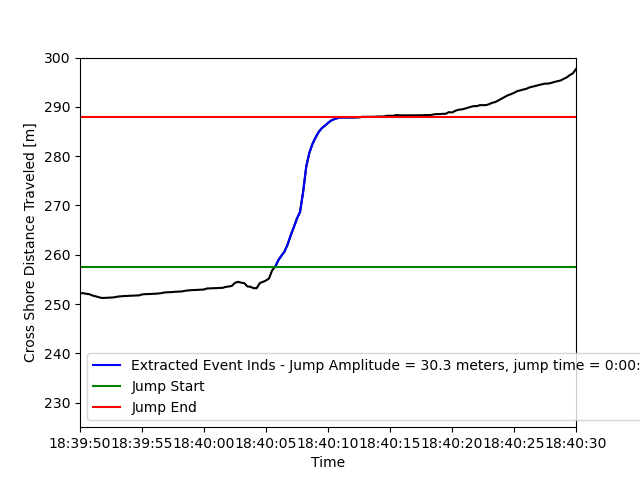

In [82]:
# Extract Jump Events from Test Trajectory
jump_event_inds = extract_jump_inds(jump_times, consecutive_values=1)
test_event_inds = jump_event_inds[0]

# Compute Amplitude of Each Jump
jump_amplitude = dist_traveled[test_event_inds[-1]] - dist_traveled[test_event_inds[0]]
jump_time = time[test_event_inds[-1]] - time[test_event_inds[0]]

# Plot Single Jump Event
fig, ax = plt.subplots()
dist_traveled = x_locations[trajectory_num,0] - x_locations[trajectory_num,:]
ax.plot(time, dist_traveled, color='k')
ax.plot(time[test_event_inds], dist_traveled[test_event_inds], color='b', 
        label=f'Extracted Event Inds - Jump Amplitude = {np.round(jump_amplitude, 1)} meters, jump time = {jump_time}')
ax.axhline(dist_traveled[test_event_inds[0]], color='g', label='Jump Start')
ax.axhline(dist_traveled[test_event_inds[-1]], color='r', label='Jump End')
ax.set_xlim(datetime(2021, 10, 8, 18, 39, 50), datetime(2021, 10, 8, 18, 40, 30))
ax.legend()
ax.set_ylim(225, 300)
ax.set_xlabel('Time')
ax.set_ylabel('Cross Shore Distance Traveled [m]')



In [84]:
# Compute all jump amplitudes and times
jump_amps = []
jump_times = []
for event in jump_event_inds:
    jump_amps.append(dist_traveled[event[-1]] - dist_traveled[event[0]])
    jump_times.append((time[event[-1]] - time[event[0]]).total_seconds())

print(jump_amps)
print(jump_times)

[30.284641264282186, 4.281622060810321, 6.714442818606358, 6.083506216138517, 24.319385093025176, 1.9500969766954768, 5.907637390424952, 1.2977556650383804, 5.797357336862547, 7.808097169832422]
[6.416641, 2.166658, 2.833322, 2.916655, 8.416633, 1.333328, 3.249987, 0.916663, 3.166654, 5.083313]


In [ ]:
# Expand this method to all trajectories on the mission
